In [1]:
import gym
import numpy as np
from matplotlib import pyplot as plt
env=gym.make('Blackjack-v1')

/home/zlz/anaconda3/envs/RL_gym/lib/python3.9/site-packages/matplotlib_inline/config.py:66: DeprecationWarning: InlineBackend._figure_formats_changed is deprecated in traitlets 4.1: use @observe and @unobserve instead.
  def _figure_formats_changed(self, name, old, new):
/home/zlz/anaconda3/envs/RL_gym/lib/python3.9/site-packages/gym/core.py:329: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/zlz/anaconda3/envs/RL_gym/lib/python3.9/site-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


### 代码4-1 用随即策略完一个回合

In [29]:
observation=env.reset()
print('初始观测={}'.format(observation))
while 1:
    print('玩家={}，庄家={}\n----------'.format(env.player,env.dealer))
    action=np.random.choice(env.action_space.n)
    observation,reward,done,info=env.step(action)
    print('动作={}\n观测={}\n奖励={}\n结束={}\n -----------'.format(action,observation,reward,done))
    if done:
        break

初始观测=(12, 8, True)
玩家=[1, 1]，庄家=[8, 3]
----------
动作=0
观测=(12, 8, True)
奖励=-1.0
结束=True
 -----------


### 代码4-2 从观测到状态

In [27]:
def ob2state(observation):
    return int(observation[0]),int(observation[1]),int(observation[2])

def plot(data):
    fig,axes=plt.subplots(1,2,figsize=(9,4))
    titles=['with aces','without aces']
    have_aces=[0,1]
    extent=[12,22,1,11]
    for title,have_ace,axis in zip(titles,have_aces,axes):
        dat=data[extent[0]:extent[1],extent[2]:extent[3],have_ace].T 
        axis.imshow(dat,extent=extent,origin='lower')
        axis.set_xlabel('player sum')
        axis.set_ylabel('dealer showing')
        axis.set_title(title)

### 代码4-3 同策回合更新策略评估

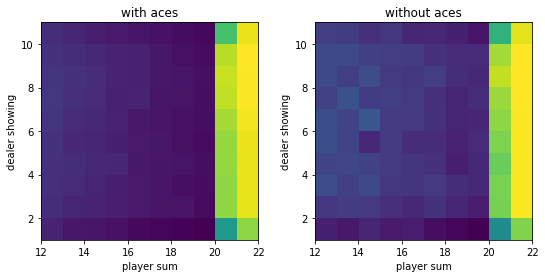

In [28]:
def evaluate_Mont_carlo(env,policy,episode_num=500000):
    q=np.zeros_like(policy)
    c=np.zeros_like(policy)

    for _ in range(episode_num):
        state_actions=[]
        observation=env.reset()
        while 1:
            state=ob2state(observation)
            action=np.random.choice(env.action_space.n,p=policy[state])
            state_actions.append((state,action))
            observation,reward,done,info=env.step(action)
            if done:
                break
        g=reward
        for state ,action in state_actions:
            c[state][action] += 1.
            q[state][action] += (g-q[state][action])/c[state][action]
    return q

policy=np.zeros((22,11,2,2))
policy[20:,:,:,0]=1 #>=20时不再要牌
policy[:20,:,:,1]=1 #<20时再要牌
q=evaluate_Mont_carlo(env,policy)
v=(q*policy).sum(axis=-1)
plot(v)

### 代码4-5 带起始探索的同策回合更新

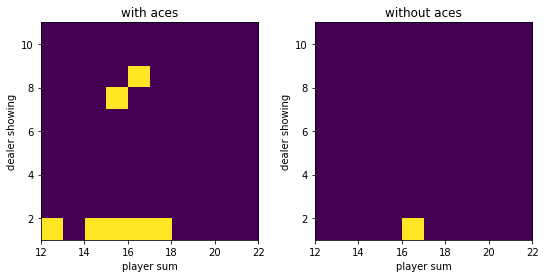

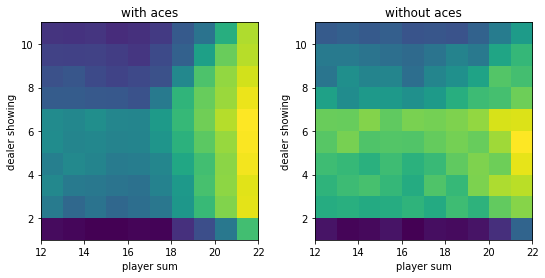

In [17]:
policy=np.zeros(shape=(22,11,2,2))
policy[:,:,:,1]=1
q=np.zeros_like(policy)
c=np.zeros_like(policy)
for i in range(500000):
    state=( np.random.randint(12,22),
            np.random.randint(1,11),
            np.random.randint(2))
    action=np.random.choice(env.action_space.n)
    env.reset()
    if state[2]:
        env.player=[1,state[0]-11]
    else:
        if state[0]==21:
            env.player=[10,9,2]
        else:
            env.player=[10,state[0]-10]
    env.dealer[0]=state[1]
    state_actions=[]
    while 1:
        state_actions.append((state,action))
        observation,reward,done,info=env.step(action)
        if done :
                break
        state=ob2state(observation)
        action=np.random.choice(env.action_space.n,p=policy[state])
    g=reward
    for state,action in state_actions:
        c[state][action] +=1
        q[state][action] += (g-q[state][action])/c[state][action]
        a=q[state].argmax()
        policy[state]=0.
        policy[state][a]=1

v=q.max(axis=-1)
plot(policy.argmax(-1))
plot(v)

### 代码4-6 基于柔性策略的同策回合更新

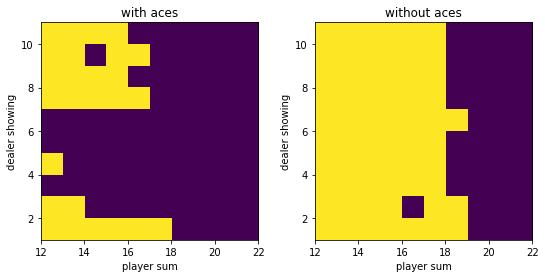

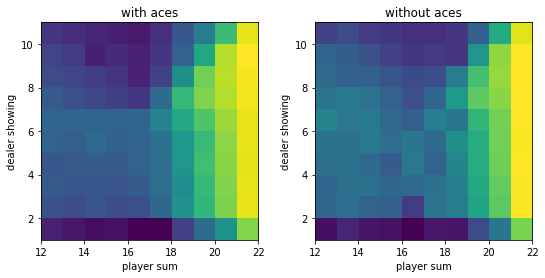

In [21]:
def MontCarlo_with_soft(env,episode_num=500000,epsilon=0.1):
    policy=np.ones((22,11,2,2))*0.5
    q=np.zeros_like(policy)
    c=np.zeros_like(policy)
    for _ in range(episode_num):
        state_actions=[]
        observation=env.reset()
        while 1:
            state=ob2state(observation)
            action=np.random.choice(env.action_space.n,p=policy[state])
            state_actions.append((state,action))
            observation,reward,done,info=env.step(action)
            if done :
                break
        g=reward
        for state,action in state_actions:
            c[state][action] += 1
            q[state][action] += (g-q[state][action])/c[state][action]
            a=q[state].argmax()
            policy[state]=epsilon/2.
            policy[state][a] += (1.-epsilon)
    return policy,q
policy,q=MontCarlo_with_soft(env)
v=q.max(axis=-1)
plot(policy.argmax(-1))
plot(v)

 ### 4-7重要性采样策略评估

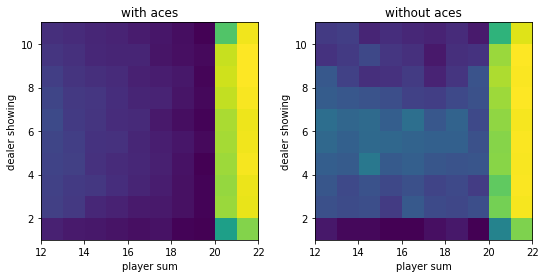

In [29]:
def evaluate_MontCarlo_Importance_sample(env,policy,behavior_policy,episode_num=500000):
    q=np.zeros_like(policy)
    c=np.zeros_like(policy)
    for _ in range(episode_num):
        state_actions=[]
        observation=env.reset()
        while 1:
            state=ob2state(observation)
            action=np.random.choice(env.action_space.n,p=behavior_policy[state])
            state_actions.append((state,action))
            observation,reward,done,info=env.step(action)
            if done :
                break
        g=reward
        rho=1.

        for state, action in state_actions:
            c[state][action] += rho
            q[state][action] += ((rho/c[state][action])*(g-q[state][action]))
            rho *= (policy[state][action]/behavior_policy[state][action])
            if rho == 0:
                break
    return q

policy=np.zeros((22,11,2,2))
policy[20:,:,:,0]=1
policy[:20,:,:,1]=1
behavior_policy=np.ones((22,11,2,2))*0.5
q=evaluate_MontCarlo_Importance_sample(env,policy,behavior_policy)
v=(q*policy).sum(axis=-1)
plot(v)

### 4-8 柔性策略重要性采样最优策略求解

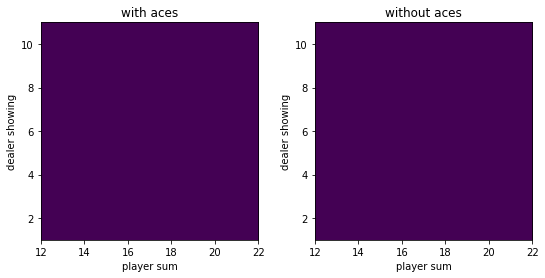

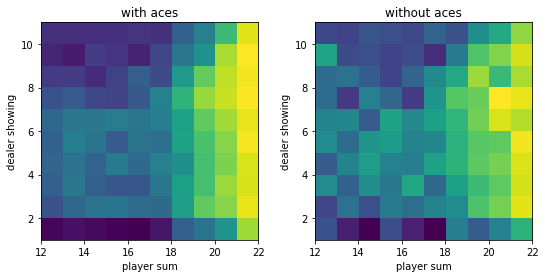

In [33]:
def MontCarlo_Importance_Sample(env,episode_num=50000):
    policy=np.zeros((22,11,2,2))
    policy[:,:,:,0]=1.
    behavior_policy=np.ones((22,11,2,2))*0.5
    q=np.zeros_like(policy)
    c=np.zeros_like(policy)
    for _ in range(episode_num):
        state_actions=[]
        observation=env.reset()
        while 1:
            state=ob2state(observation)
            action=np.random.choice(env.action_space.n,p=behavior_policy[state])
            state_actions.append((state,action))
            observation,reward,done,info=env.step(action)
            if done:
                break
        g=reward
        rho =1.
        for state,reward in state_actions:
            c[state][action] += rho
            q[state][action] += (rho/c[state][action]*(g-q[state][action]))
            a=q[state].argmax()
            policy[state]=0
            policy[state][a]=1.
            if rho==0:
                break
            rho /=behavior_policy[state][action]
    return policy,q

policy,q=MontCarlo_Importance_Sample(env)
v=q.max(axis=-1)
plot(policy.argmax(-1))
plot(v)